# Part 1: Introduction

A full documentation of the data we used, relavent links and relavent schema

Flights were sourced from here: https://www.kaggle.com/datasets/usdot/flight-delays?select=flights.csv

Weather was sourced from here: https://asmith.ucdavis.edu/data/prism-weather

AirportLocations.csv was sourced from: https://geodata.bts.gov/datasets/usdot::aviation-facilities/about

For weather use the settings: Temporal unit should be daily, use county as spatial unit, start and end year are both 2015, months go from 1 to 12, states are all states, choose variables are tmin, tmax, tavg, ppt, dday_a5C, dday_b15C



# Part 2: Data Loading and Preprocessing

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import kagglehub
import seaborn as sns

State regions were determined by the following image (kind of arbitrary). We decided to set AK to north and HI to pacific, this is here for the purpose of hypothesis testing later on

![Alt Text](region.png)

In [6]:
state_to_region_dict = {
    'WA': 'northwest',
    'OR': 'northwest',
    'ID': 'northwest',
    'MT': 'northwest',
    'WY': 'northwest',
    'CA': 'west',
    'NV': 'west',
    'UT': 'southwest',
    'AZ': 'southwest',
    'CO': 'southwest',
    'NM': 'southwest',
    'TX': 'southwest',
    'OK': 'southwest',
    'ND': 'midwest',
    'SD': 'midwest',
    'NE': 'midwest',
    'KS': 'midwest',
    'MN': 'midwest',
    'IA': 'midwest',
    'MO': 'midwest',
    'WI': 'midwest',
    'IL': 'midwest',
    'MI': 'midwest',
    'KY': 'midwest',
    'IN': 'midwest',
    'OH': 'midwest',
    'AR': 'southeast',
    'LA': 'southeast',
    'MS': 'southeast',
    'AL': 'southeast',
    'GA': 'southeast',
    'FL': 'southeast',
    'TN': 'southeast',
    'NC': 'southeast',
    'SC': 'southeast',
    'VA': 'midatlantic',
    'WV': 'midatlantic',
    'MD': 'midatlantic',
    'DE': 'midatlantic',
    'DC': 'midatlantic',
    'NJ': 'midatlantic',
    'PA': 'midatlantic',
    'NY': 'midatlantic',
    'CT': 'newengland',
    'RI': 'newengland',
    'MA': 'newengland',
    'NH': 'newengland',
    'VT': 'newengland',
    'ME': 'newengland',
    'AK': 'north',
    'HI': 'pacific'
}

In [7]:
flights_df = pl.read_csv('flights.csv')
airport_loc_df = pl.read_csv('AirportLocations.csv')
airlines_df = pl.read_csv('airlines.csv')
weather_df = pl.read_csv('weather.csv')

### ER Diagram

This entity relationship diagram is based on the 4 datasets we are using. Namely, the entities below correspond to the dataframes as follows: flight (flight_df), airport (airport_loc_df), airline (airlines_df), weather (weather_df). The relationships that exist are as follows:
- A flight departs from/arrives at exactly 1 aiport (respectively). An airport can be the departure location/arrival location of multiple flights.
- A flight is operated by exaclty 1 airline. An airline may operate multiple flights.
- An airport experiences various weather conditions (on different days). A specific weather condition on a specific day is experienced by exactly 1 airport.

For this last relationship, we assume that all (location, date) pairs are different, and that there is only 1 airport located in each county. That is, weather conditions at a specific location (and hence corresponding to a specific airport) are unique.

Note: Some attributes are left off of the flight entity (AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY, WEATHER_DELAY) as they were not used going forward and the "CANCELLATION_REASON" column essentially had the same information.

![Alt Text](project_er_diagram.png)

Creating separate dataframes for flights that are delayed vs. those that are not that may be of interest later.

In [8]:
delays_df = flights_df.filter(pl.col("DEPARTURE_DELAY") > 0)
ontime_df = flights_df.filter(pl.col("DEPARTURE_DELAY") <= 0)

Here we are joining the county information so that we can compare weather conditions at the origin airport of each flight. Then, we are creating a datetime based on the three columns of 'YEAR', 'MONTH', and 'DAY' to allow for ease of joining with the weather dataset that has this format.

In [9]:
airport_loc_df = airport_loc_df.select(["ARPT_ID", "COUNTY_NAME", "STATE_CODE"])
flights_df = flights_df.join(
    airport_loc_df, 
    left_on="ORIGIN_AIRPORT", 
    right_on="ARPT_ID", 
    how="left"
)
flights_df = flights_df.with_columns(
    pl.datetime(
        year=pl.col("YEAR"), 
        month=pl.col("MONTH"), 
        day=pl.col("DAY")
    ).cast(pl.Date).alias("date")
)
flights_df

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,COUNTY_NAME,STATE_CODE,date
i64,i64,i64,i64,str,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,str,str,date
2015,1,1,4,"""AS""",98,"""N407AS""","""ANC""","""SEA""",5,2354,-11,21,15,205,194,169,1448,404,4,430,408,-22,0,0,null,null,null,null,null,null,"""ANCHORAGE""","""AK""",2015-01-01
2015,1,1,4,"""AA""",2336,"""N3KUAA""","""LAX""","""PBI""",10,2,-8,12,14,280,279,263,2330,737,4,750,741,-9,0,0,null,null,null,null,null,null,"""LOS ANGELES""","""CA""",2015-01-01
2015,1,1,4,"""US""",840,"""N171US""","""SFO""","""CLT""",20,18,-2,16,34,286,293,266,2296,800,11,806,811,5,0,0,null,null,null,null,null,null,"""SAN MATEO""","""CA""",2015-01-01
2015,1,1,4,"""AA""",258,"""N3HYAA""","""LAX""","""MIA""",20,15,-5,15,30,285,281,258,2342,748,8,805,756,-9,0,0,null,null,null,null,null,null,"""LOS ANGELES""","""CA""",2015-01-01
2015,1,1,4,"""AS""",135,"""N527AS""","""SEA""","""ANC""",25,24,-1,11,35,235,215,199,1448,254,5,320,259,-21,0,0,null,null,null,null,null,null,"""KING""","""WA""",2015-01-01
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2015,12,31,4,"""B6""",688,"""N657JB""","""LAX""","""BOS""",2359,2355,-4,22,17,320,298,272,2611,749,4,819,753,-26,0,0,null,null,null,null,null,null,"""LOS ANGELES""","""CA""",2015-12-31
2015,12,31,4,"""B6""",745,"""N828JB""","""JFK""","""PSE""",2359,2355,-4,17,12,227,215,195,1617,427,3,446,430,-16,0,0,null,null,null,null,null,null,"""QUEENS""","""NY""",2015-12-31
2015,12,31,4,"""B6""",1503,"""N913JB""","""JFK""","""SJU""",2359,2350,-9,17,7,221,222,197,1598,424,8,440,432,-8,0,0,null,null,null,null,null,null,"""QUEENS""","""NY""",2015-12-31


(Don't run the below cell more than once) Next, we further format the 'date' and 'county_name' columns of weather_df to match that of flights_df.

In [10]:
weather_df = weather_df.with_columns(
    pl.col("date").cast(pl.Utf8).str.strptime(pl.Date, "%Y%m%d").alias("date")
)
weather_df = weather_df.with_columns(
    pl.col("county_name").str.to_lowercase().alias("county_name")
)
weather_df

st_abb,st_code,county_name,fips,date,stability,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C
str,i64,str,i64,date,str,f64,f64,f64,f64,f64,f64
"""AL""",1,"""autauga""",1001,2015-01-01,"""stable""",-0.835,10.961,5.063,0.059,1.909,9.937
"""AL""",1,"""autauga""",1001,2015-01-02,"""stable""",0.276,13.216,6.746,3.863,3.008,8.254
"""AL""",1,"""autauga""",1001,2015-01-03,"""stable""",8.511,12.552,10.531,14.217,5.532,4.469
"""AL""",1,"""autauga""",1001,2015-01-04,"""stable""",12.328,20.585,16.457,48.919,11.456,0.668
"""AL""",1,"""autauga""",1001,2015-01-05,"""stable""",2.642,15.865,9.254,0.0,4.684,5.841
…,…,…,…,…,…,…,…,…,…,…,…
"""WY""",56,"""weston""",56045,2015-12-27,"""stable""",-19.242,-6.704,-12.973,0.0,0.0,27.973
"""WY""",56,"""weston""",56045,2015-12-28,"""stable""",-18.188,-2.366,-10.277,0.0,0.0,25.277
"""WY""",56,"""weston""",56045,2015-12-29,"""stable""",-20.651,-3.123,-11.887,0.0,0.0,26.887


Cross Referenced Data from here in order to ensure that the temperatures were correctly aligned: https://www.timeanddate.com/weather/usa/new-york/historic?month=12&year=2015

Then, we joined the flights_df with weather_df on the date and both county name and state to have the weather conditions at a particular airport on a particular day. We initially only merged on date and county name. However, upon realizing that there were cases with counties of the same name in different states, we also included state to also be merged to create result_df overall.

In [11]:
flights_df = flights_df.with_columns(
    pl.col("COUNTY_NAME").str.to_lowercase().alias("COUNTY_NAME")
)

result_df = flights_df.join(
    weather_df,
    left_on=["COUNTY_NAME", "date", "STATE_CODE"],
    right_on=["county_name", "date", "st_abb"],
    how="left"
)

flights_df

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,COUNTY_NAME,STATE_CODE,date
i64,i64,i64,i64,str,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,str,str,date
2015,1,1,4,"""AS""",98,"""N407AS""","""ANC""","""SEA""",5,2354,-11,21,15,205,194,169,1448,404,4,430,408,-22,0,0,null,null,null,null,null,null,"""anchorage""","""AK""",2015-01-01
2015,1,1,4,"""AA""",2336,"""N3KUAA""","""LAX""","""PBI""",10,2,-8,12,14,280,279,263,2330,737,4,750,741,-9,0,0,null,null,null,null,null,null,"""los angeles""","""CA""",2015-01-01
2015,1,1,4,"""US""",840,"""N171US""","""SFO""","""CLT""",20,18,-2,16,34,286,293,266,2296,800,11,806,811,5,0,0,null,null,null,null,null,null,"""san mateo""","""CA""",2015-01-01
2015,1,1,4,"""AA""",258,"""N3HYAA""","""LAX""","""MIA""",20,15,-5,15,30,285,281,258,2342,748,8,805,756,-9,0,0,null,null,null,null,null,null,"""los angeles""","""CA""",2015-01-01
2015,1,1,4,"""AS""",135,"""N527AS""","""SEA""","""ANC""",25,24,-1,11,35,235,215,199,1448,254,5,320,259,-21,0,0,null,null,null,null,null,null,"""king""","""WA""",2015-01-01
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2015,12,31,4,"""B6""",688,"""N657JB""","""LAX""","""BOS""",2359,2355,-4,22,17,320,298,272,2611,749,4,819,753,-26,0,0,null,null,null,null,null,null,"""los angeles""","""CA""",2015-12-31
2015,12,31,4,"""B6""",745,"""N828JB""","""JFK""","""PSE""",2359,2355,-4,17,12,227,215,195,1617,427,3,446,430,-16,0,0,null,null,null,null,null,null,"""queens""","""NY""",2015-12-31
2015,12,31,4,"""B6""",1503,"""N913JB""","""JFK""","""SJU""",2359,2350,-9,17,7,221,222,197,1598,424,8,440,432,-8,0,0,null,null,null,null,null,null,"""queens""","""NY""",2015-12-31


This next part filters out values where 'tavg' is null to basically drop rows without temperature data. We also create a new column called 'TOTAL_DELAY' that is a measure of the overall delay based on summing the 'DEPARTURE_DELAY' and 'ARRIVAL_DELAY' for a flight, this creates the result_important_df that we will use going forward.

In [12]:
result_important_df = result_df.filter(pl.col('tavg').is_not_null())
result_important_df = result_important_df.with_columns(
    (pl.col('DEPARTURE_DELAY') + pl.col('ARRIVAL_DELAY')).alias('TOTAL_DELAY')
)
result_important_df

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,COUNTY_NAME,STATE_CODE,date,st_code,fips,stability,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C,TOTAL_DELAY
i64,i64,i64,i64,str,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,str,str,date,i64,i64,str,f64,f64,f64,f64,f64,f64,i64
2015,1,1,4,"""AA""",2336,"""N3KUAA""","""LAX""","""PBI""",10,2,-8,12,14,280,279,263,2330,737,4,750,741,-9,0,0,null,null,null,null,null,null,"""los angeles""","""CA""",2015-01-01,6,6037,"""stable""",-2.162,7.71,2.774,0.009,0.621,12.226,-17
2015,1,1,4,"""US""",840,"""N171US""","""SFO""","""CLT""",20,18,-2,16,34,286,293,266,2296,800,11,806,811,5,0,0,null,null,null,null,null,null,"""san mateo""","""CA""",2015-01-01,6,6081,"""stable""",2.561,12.746,7.654,0.0,3.173,7.346,3
2015,1,1,4,"""AA""",258,"""N3HYAA""","""LAX""","""MIA""",20,15,-5,15,30,285,281,258,2342,748,8,805,756,-9,0,0,null,null,null,null,null,null,"""los angeles""","""CA""",2015-01-01,6,6037,"""stable""",-2.162,7.71,2.774,0.009,0.621,12.226,-14
2015,1,1,4,"""AS""",135,"""N527AS""","""SEA""","""ANC""",25,24,-1,11,35,235,215,199,1448,254,5,320,259,-21,0,0,null,null,null,null,null,null,"""king""","""WA""",2015-01-01,53,53033,"""stable""",-6.204,0.605,-2.8,0.061,0.0,17.8,-22
2015,1,1,4,"""DL""",806,"""N3730B""","""SFO""","""MSP""",25,20,-5,18,38,217,230,206,1589,604,6,602,610,8,0,0,null,null,null,null,null,null,"""san mateo""","""CA""",2015-01-01,6,6081,"""stable""",2.561,12.746,7.654,0.0,3.173,7.346,3
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2015,12,31,4,"""B6""",688,"""N657JB""","""LAX""","""BOS""",2359,2355,-4,22,17,320,298,272,2611,749,4,819,753,-26,0,0,null,null,null,null,null,null,"""los angeles""","""CA""",2015-12-31,6,6037,"""stable""",-0.456,13.363,6.454,0.0,2.975,8.546,-30
2015,12,31,4,"""B6""",745,"""N828JB""","""JFK""","""PSE""",2359,2355,-4,17,12,227,215,195,1617,427,3,446,430,-16,0,0,null,null,null,null,null,null,"""queens""","""NY""",2015-12-31,36,36081,"""stable""",4.968,9.84,7.404,8.014,2.405,7.596,-20
2015,12,31,4,"""B6""",1503,"""N913JB""","""JFK""","""SJU""",2359,2350,-9,17,7,221,222,197,1598,424,8,440,432,-8,0,0,null,null,null,null,null,null,"""queens""","""NY""",2015-12-31,36,36081,"""stable""",4.968,9.84,7.404,8.014,2.405,7.596,-17


# Part 3: Exploratory Data Analysis

We will now split in to test and train sets and proceed with EDA on the train set

In [13]:
from sklearn.model_selection import train_test_split

target = ['DEPARTURE_DELAY']

X_train, X_test = train_test_split(result_important_df, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)

(3946641, 44)
(986661, 44)


Let us now get some understanding of what our data looks like

In [14]:
basic_stats = X_train.describe()
basic_stats

statistic,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,COUNTY_NAME,STATE_CODE,date,st_code,fips,stability,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C,TOTAL_DELAY
str,f64,f64,f64,f64,str,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64
"""count""",3.946641e6,3.946641e6,3.946641e6,3.946641e6,"""3946641""",3.946641e6,"""3936396""","""3946641""","""3946641""",3.946641e6,3.883826e6,3.883826e6,3.88178e6,3.88178e6,3.946636e6,3.870653e6,3.870653e6,3.946641e6,3.879364e6,3.879364e6,3.946641e6,3.879364e6,3.870653e6,3.946641e6,3.946641e6,"""65476""",748069.0,748069.0,748069.0,748069.0,748069.0,"""3946641""","""3946641""","""3946641""",3.946641e6,3.946641e6,"""3946641""",3.946641e6,3.946641e6,3.946641e6,3.946641e6,3.946641e6,3.946641e6,3.870653e6
"""null_count""",0.0,0.0,0.0,0.0,"""0""",0.0,"""10245""","""0""","""0""",0.0,62815.0,62815.0,64861.0,64861.0,5.0,75988.0,75988.0,0.0,67277.0,67277.0,0.0,67277.0,75988.0,0.0,0.0,"""3881165""",3.198572e6,3.198572e6,3.198572e6,3.198572e6,3.198572e6,"""0""","""0""","""0""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,75988.0
"""mean""",2015.0,6.210124,15.688564,3.915177,null,2245.088752,null,null,null,1328.087608,1334.357638,9.938314,16.189364,1356.30601,140.371947,135.737219,112.143774,809.604327,1472.805069,7.416505,1495.410346,1477.682653,5.008817,0.002664,0.01659,null,13.563749,0.072813,18.867832,23.658491,3.020876,null,null,"""2015-06-22 08:01:36.806000""",25.799725,25891.659535,null,9.962532,20.902294,15.432405,2.907277,11.70645,4.304782,14.872212
"""std""",0.0,3.383145,8.773783,1.993141,null,1770.15471,null,null,null,482.854655,496.066015,37.484086,9.006211,497.69906,72.536372,71.711831,69.724378,583.405619,521.128129,5.693446,505.100335,525.336428,39.727851,0.051541,0.12773,null,28.165221,2.051093,47.261881,43.07296,20.797326,null,null,null,16.212447,16257.509791,null,10.137833,10.735128,10.267412,7.713806,8.044376,6.503547,75.973164
"""min""",2015.0,1.0,1.0,1.0,"""AA""",1.0,"""7819A""","""ABE""","""ABE""",1.0,1.0,-68.0,1.0,1.0,20.0,16.0,8.0,21.0,1.0,1.0,1.0,1.0,-87.0,0.0,0.0,"""A""",0.0,0.0,0.0,0.0,0.0,"""ada""","""AL""","""2015-01-01""",1.0,1045.0,"""stable""",-34.64,-24.915,-28.471,0.0,0.0,0.0,-155.0
"""25%""",2015.0,3.0,8.0,2.0,null,769.0,null,null,null,915.0,920.0,-5.0,11.0,935.0,86.0,83.0,61.0,373.0,1057.0,4.0,1112.0,1101.0,-13.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,null,null,"""2015-03-27""",12.0,12057.0,null,3.187,14.168,8.779,0.0,4.265,0.0,-17.0
"""50%""",2015.0,6.0,16.0,4.0,null,1753.0,null,null,null,1322.0,1328.0,-1.0,14.0,1341.0,121.0,118.0,94.0,646.0,1509.0,6.0,1520.0,1512.0,-5.0,0.0,0.0,null,2.0,0.0,2.0,4.0,0.0,null,null,"""2015-06-17""",25.0,25025.0,null,10.994,22.913,16.908,0.003,11.908,1.058,-6.0
"""75%""",2015.0,9.0,23.0,6.0,null,3356.0,null,null,null,1730.0,1740.0,8.0,19.0,1754.0,170.0,166.0,142.0,1041.0,1911.0,9.0,1917.0,1916.0,8.0,0.0,0.0,null,18.0,0.0,19.0,30.0,0.0,null,null,"""2015-09-06""",40.0,40143.0,null,18.206,29.183,23.629,1.634,18.63,6.34,15.0
"""max""",2015.0,12.0,31.0,7.0,"""WN""",9855.0,"""N9EAMQ""","""XNA""","""YUM""",2359.0,2400.0,1878.0,225.0,2400.0,718.0,735.0,690.0,4983.0,2400.0,248.0,2400.0,2400.0,1898.0,1.0,1.0,"""D""",1134.0,440.0,1878.0,1331.0,1211.0,"""yellowstone""","""WY""","""2015-12-31""",56.0,56039.0,"""stable""",29.969,44.006,36.688,142.287,31.688,43.471,3776.0


In [15]:
info = X_train.schema
info

Schema([('YEAR', Int64),
        ('MONTH', Int64),
        ('DAY', Int64),
        ('DAY_OF_WEEK', Int64),
        ('AIRLINE', String),
        ('FLIGHT_NUMBER', Int64),
        ('TAIL_NUMBER', String),
        ('ORIGIN_AIRPORT', String),
        ('DESTINATION_AIRPORT', String),
        ('SCHEDULED_DEPARTURE', Int64),
        ('DEPARTURE_TIME', Int64),
        ('DEPARTURE_DELAY', Int64),
        ('TAXI_OUT', Int64),
        ('WHEELS_OFF', Int64),
        ('SCHEDULED_TIME', Int64),
        ('ELAPSED_TIME', Int64),
        ('AIR_TIME', Int64),
        ('DISTANCE', Int64),
        ('WHEELS_ON', Int64),
        ('TAXI_IN', Int64),
        ('SCHEDULED_ARRIVAL', Int64),
        ('ARRIVAL_TIME', Int64),
        ('ARRIVAL_DELAY', Int64),
        ('DIVERTED', Int64),
        ('CANCELLED', Int64),
        ('CANCELLATION_REASON', String),
        ('AIR_SYSTEM_DELAY', Int64),
        ('SECURITY_DELAY', Int64),
        ('AIRLINE_DELAY', Int64),
        ('LATE_AIRCRAFT_DELAY', Int64),
        ('WEAT

Looking for potential outliers
Although it is a lot more rare for flights to be delayed for amounts > a few hundred minutes, there is really a considerable amount of data points even at the higher end, so we did not decide to remove any outliers, as this should not affect a lot of our analysis that is based on delay as a boolean variable anyways.\
\
For instance, for departure delays, there are values at 1878, 1670, 1649, 1631, 1625, 1609, 1557, 1542, 1522, 1496, 1480, 1475, 1461, 1458, 1457, 1450, 1429, etc. minutes. So for the most part there is not clear separation of what would be a good cutoff. \
\
To better visualize the distributions, see the following graphs for DEPARTURE_DELAY, ARRIVAL_DELAY, and TOTAL_DELAY. It should also be noted that usually DEPARTURE_DELAY was very correlated with ARRIVAL_DELAY and TOTAL_DELAY was approximately twice the DEPARTURE_DELAY, which is approximately twice the ARRIVAL_DELAY.

Text(0, 0.5, 'Count')

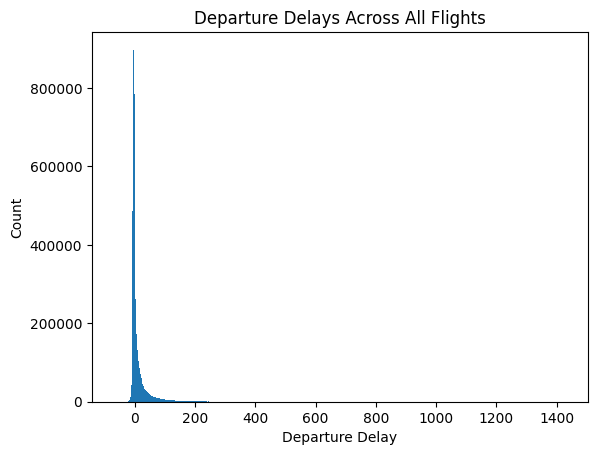

In [16]:
X_train['DEPARTURE_DELAY'].max()
_ = plt.hist(X_train['DEPARTURE_DELAY'], bins = 700)
plt.title("Departure Delays Across All Flights")
plt.xlabel("Departure Delay")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

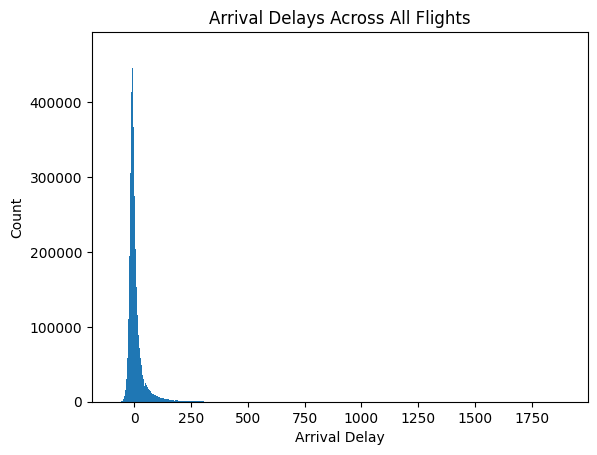

In [17]:
# Repeating the same for Arrival Delays
_ = plt.hist(X_train['ARRIVAL_DELAY'], bins = 500)
plt.title("Arrival Delays Across All Flights")
plt.xlabel("Arrival Delay")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

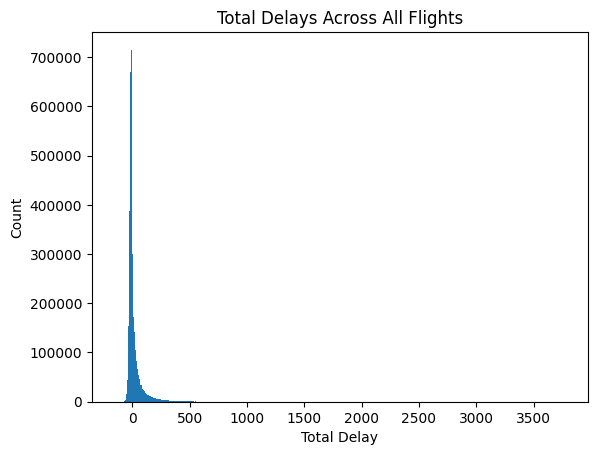

In [18]:
# Repeating the same for Total Delays
_ = plt.hist(X_train['TOTAL_DELAY'], bins = 500)
plt.title("Total Delays Across All Flights")
plt.xlabel("Total Delay")
plt.ylabel("Count")

Next, we looked at if there was any visible differences in delays across different months. There was nothing clearly discernable. Though perhaps for a month like December it looked like there were some more higher values outside of the box of the boxplot than a month like July. We also realized that the dataset for some reason did not contain any data for October.

In [ ]:
data1 = (X_train.filter(pl.col('MONTH') == 1)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data2 = (X_train.filter(pl.col('MONTH') == 2)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data3 = (X_train.filter(pl.col('MONTH') == 3)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data4 = (X_train.filter(pl.col('MONTH') == 4)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data5 = (X_train.filter(pl.col('MONTH') == 5)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data6 = (X_train.filter(pl.col('MONTH') == 6)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data7 = (X_train.filter(pl.col('MONTH') == 7)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data8 = (X_train.filter(pl.col('MONTH') == 8)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data9 = (X_train.filter(pl.col('MONTH') == 9)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data10 = (X_train.filter(pl.col('MONTH') == 10)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data11 = (X_train.filter(pl.col('MONTH') == 11)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data12 = (X_train.filter(pl.col('MONTH') == 12)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
boxplot_data = [data1.to_numpy().flatten(), data2.to_numpy().flatten(), data3.to_numpy().flatten(),
                data4.to_numpy().flatten(), data5.to_numpy().flatten(), data6.to_numpy().flatten(),
                data7.to_numpy().flatten(), data8.to_numpy().flatten(), data9.to_numpy().flatten(),
                data10.to_numpy().flatten(), data11.to_numpy().flatten(), data12.to_numpy().flatten()]
fig = plt.figure(figsize = (7, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(boxplot_data)
ax.set_ylim(X_train.select(pl.min("DEPARTURE_DELAY"))[0,0], X_train.select(pl.max("DEPARTURE_DELAY"))[0,0])
plt.show()

We convert state_to_region_dict to a dataframe for joining purposes and join it with X_train to create X_train_region that has the regions corresponding to the states that the departure airport is associated with. The state_to_region_df created with also be used later on in testing Hypothesis 2.\
\
From this, we creates a boxplot of the data for each region. We realized that there was no data for any flights departing from Hawaii nor Alaska, thus there was no data for the regions "pacific" and "north". It was noticed that there were some observable differences in regions like the Northwest and New England having departure delays that were concentrated at lower values whereas for the rest of the regions there was a larger spread and also considerable amount of data points for longer departure delays.

In [ ]:
state_to_region_df = pl.from_dict(state_to_region_dict)
states = pl.Series(state_to_region_df.columns)
state_to_region_df = state_to_region_df.transpose()
state_to_region_df = state_to_region_df.insert_column(1, states)
state_to_region_df.columns = ['region', 'STATE_CODE']

In [ ]:
# Join X_train with this to add a new column with the regions
X_train_region = X_train.join(state_to_region_df, on = 'STATE_CODE', how = 'left')

nw = (X_train_region.filter(pl.col('region') == "northwest")).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
w = (X_train_region.filter(pl.col('region') == "west")).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
sw = (X_train_region.filter(pl.col('region') == "southwest")).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
mw = (X_train_region.filter(pl.col('region') == "midwest")).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
se = (X_train_region.filter(pl.col('region') == "southeast")).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
ma = (X_train_region.filter(pl.col('region') == "midatlantic")).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
ne = (X_train_region.filter(pl.col('region') == "newengland")).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
n = (X_train_region.filter(pl.col('region') == "north")).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
p = (X_train_region.filter(pl.col('region') == "pacific")).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
boxplot_data = [nw.to_numpy().flatten(), w.to_numpy().flatten(), sw.to_numpy().flatten(),
                mw.to_numpy().flatten(), se.to_numpy().flatten(), ma.to_numpy().flatten(),
                ne.to_numpy().flatten(), n.to_numpy().flatten(), p.to_numpy().flatten()]
fig = plt.figure(figsize = (7, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(boxplot_data)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], ['northwest', 'west', 'southwest', 'midwest', 'southeast', 'mid-atlantic', 'new england', 'north', 'pacific'])
ax.set_ylim(X_train.select(pl.min("DEPARTURE_DELAY"))[0,0], X_train.select(pl.max("DEPARTURE_DELAY"))[0,0])
plt.show()

Below is a correlation matrix for specific columns of interest to observe for an correlation between potential predictor variables.

In [19]:
columns_of_interest = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'DISTANCE', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'tmin', 'tmax', 'tavg', 'ppt', 'dday_a5C', 'dday_b15C']
X_train_numerical = X_train.select(columns_of_interest)
df = X_train_numerical.to_pandas()
corr_matrix = df.corr()
corr_matrix

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,ELAPSED_TIME,AIR_TIME,WHEELS_ON,DISTANCE,ARRIVAL_DELAY,DIVERTED,CANCELLED,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C
SCHEDULED_DEPARTURE,1.000000,0.962233,0.115284,0.003903,0.935480,-0.034572,-0.032146,0.659905,-0.027640,0.105271,-0.001100,0.012024,0.019178,0.015066,0.017344,0.005907,0.015707,-0.017254
DEPARTURE_TIME,0.962233,1.000000,0.178411,0.011233,0.971042,-0.038370,-0.037361,0.680601,-0.034474,0.166297,0.001254,0.008537,0.015856,0.010246,0.013188,0.013549,0.013354,-0.011402
DEPARTURE_DELAY,0.115284,0.178411,1.000000,0.057032,0.168854,0.028974,0.021429,0.059745,0.022554,0.945319,0.022244,0.031957,0.001969,-0.015177,-0.006960,0.060322,0.009501,0.028679
TAXI_OUT,0.003903,0.011233,0.057032,1.000000,0.036449,0.209675,0.086574,0.028740,0.071450,0.228042,0.011847,0.005653,-0.055480,-0.089860,-0.074373,0.032480,-0.052435,0.093206
WHEELS_OFF,0.935480,0.971042,0.168854,0.036449,1.000000,-0.043546,-0.046082,0.701176,-0.045990,0.161964,0.001438,0.005178,0.014069,0.006840,0.010525,0.014787,0.011508,-0.008076
ELAPSED_TIME,-0.034572,-0.038370,0.028974,0.209675,-0.043546,1.000000,0.989078,0.027310,0.971945,0.033532,NaN,NaN,0.003841,-0.015541,-0.006225,-0.006967,-0.009281,0.001395
AIR_TIME,-0.032146,-0.037361,0.021429,0.086574,-0.046082,0.989078,1.000000,0.024980,0.984889,-0.004563,NaN,NaN,0.011677,-0.003690,0.003840,-0.011555,-0.002962,-0.012147
WHEELS_ON,0.659905,0.680601,0.059745,0.028740,0.701176,0.027310,0.024980,1.000000,0.022695,0.059274,0.006916,NaN,-0.000731,-0.004399,-0.002660,0.005032,-0.003745,0.000882
DISTANCE,-0.027640,-0.034474,0.022554,0.071450,-0.045990,0.971945,0.984889,0.022695,1.000000,-0.023186,0.013365,-0.034271,0.027400,0.018948,0.023433,-0.020159,0.013118,-0.034439
ARRIVAL_DELAY,0.105271,0.166297,0.945319,0.228042,0.161964,0.033532,-0.004563,0.059274,-0.023186,1.000000,NaN,NaN,-0.001721,-0.016689,-0.009573,0.065270,0.008151,0.032704


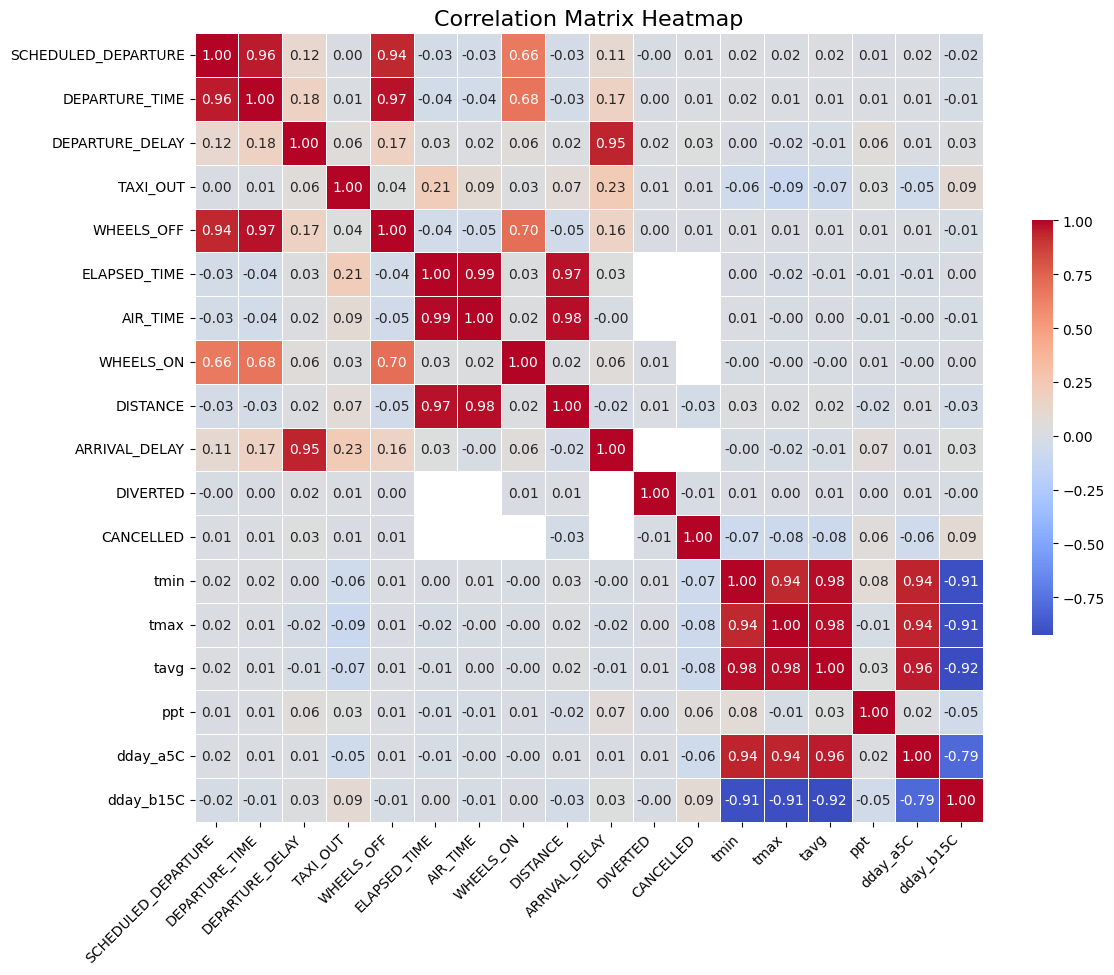

In [20]:
'''
VISUAL 1: Naturally as we are interested in DEPARTURE and ARRIVAL delay when choosing features, we should choose features that seem to be highly correlated with these delays
We will use 2 metrics that I think do a good job of measuring correlation, 1 is the standard pearson correlation, then to compare categorical values we will use the CramerV correlation metric
'''
plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5}
)

plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


As we can see there are very weak correlations, but what if we filter for precipitation > 1?

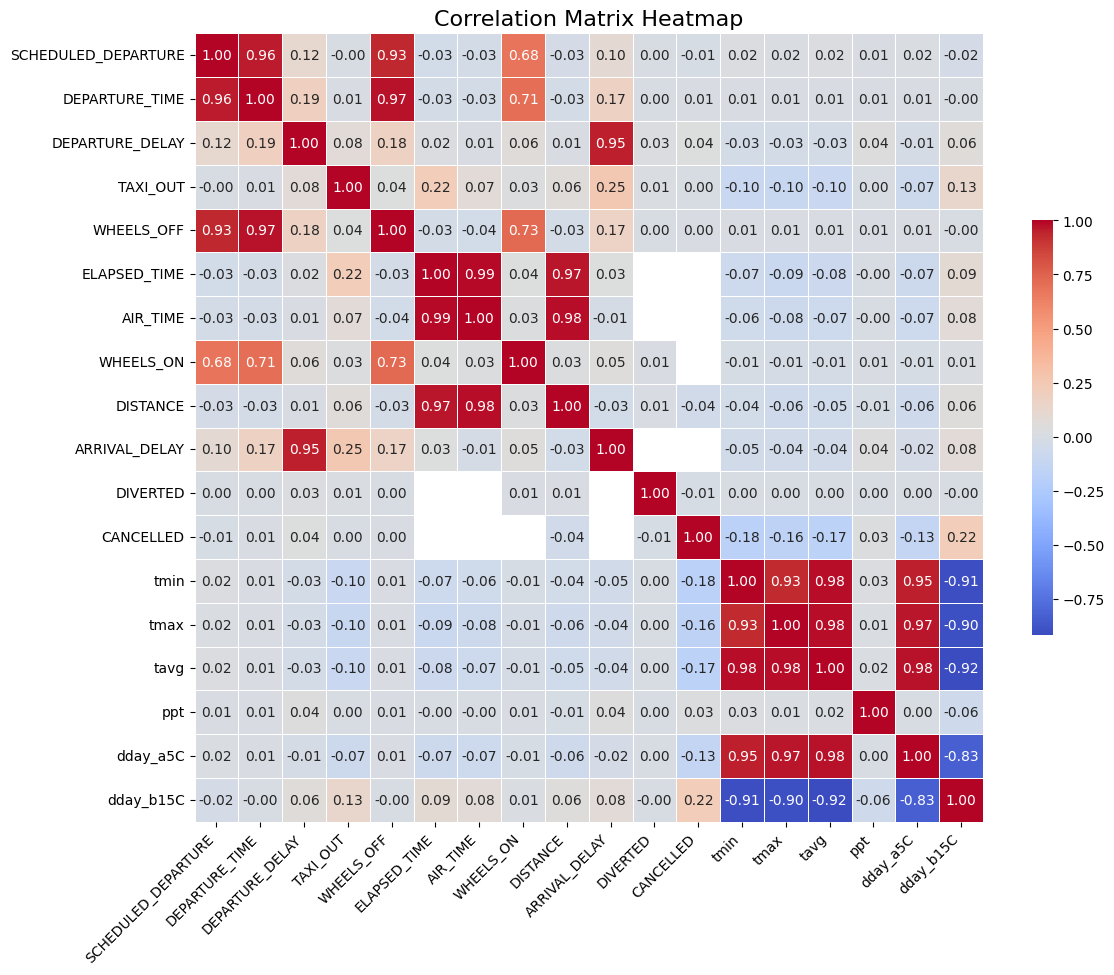

(613346, 18)


In [21]:
df_ppt_filtered = df[df['ppt'] > 5]
corr_matrix = df_ppt_filtered.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5}
)

plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
print(df_ppt_filtered.shape)

C:\Users\nball\AppData\Local\Temp\ipykernel_17024\2889801515.py:1: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  origin_counts = X_train.group_by("ORIGIN_AIRPORT").count()


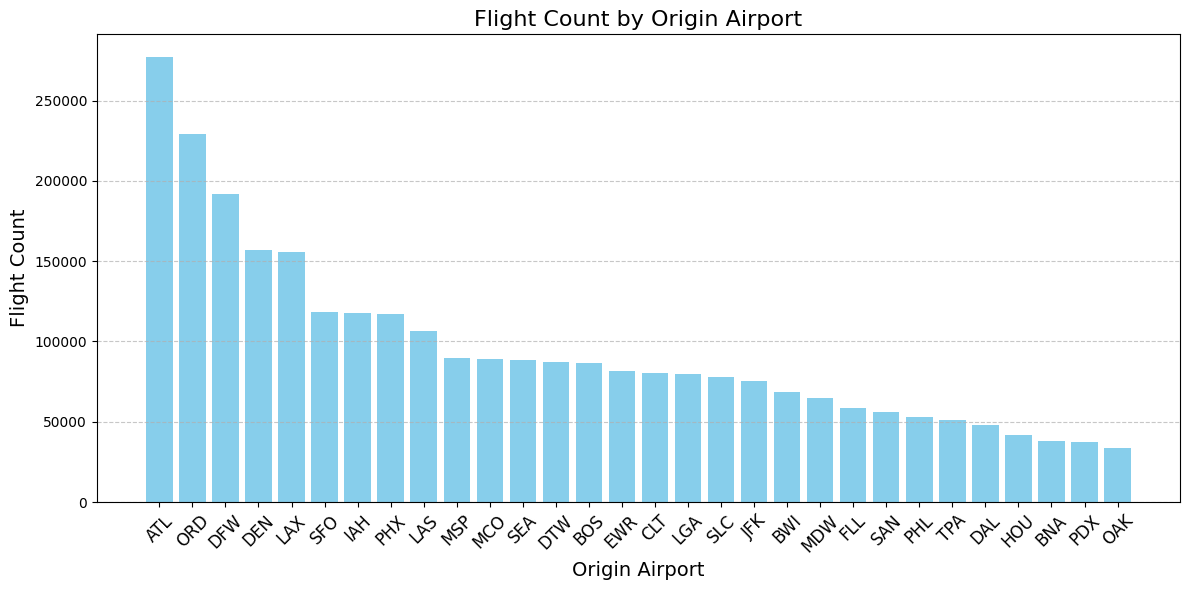

In [22]:
origin_counts = X_train.group_by("ORIGIN_AIRPORT").count()
origin_counts_pd = origin_counts.to_pandas()
origin_counts_pd = origin_counts_pd.sort_values(by="count", ascending=False)
top_30 = origin_counts_pd.head(30)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(top_30["ORIGIN_AIRPORT"], top_30["count"], color="skyblue")
plt.xlabel("Origin Airport", fontsize=14)
plt.ylabel("Flight Count", fontsize=14)
plt.title("Flight Count by Origin Airport", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\nball\AppData\Local\Temp\ipykernel_17024\1305936786.py:1: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  airline_counts = X_train.group_by("AIRLINE").count()


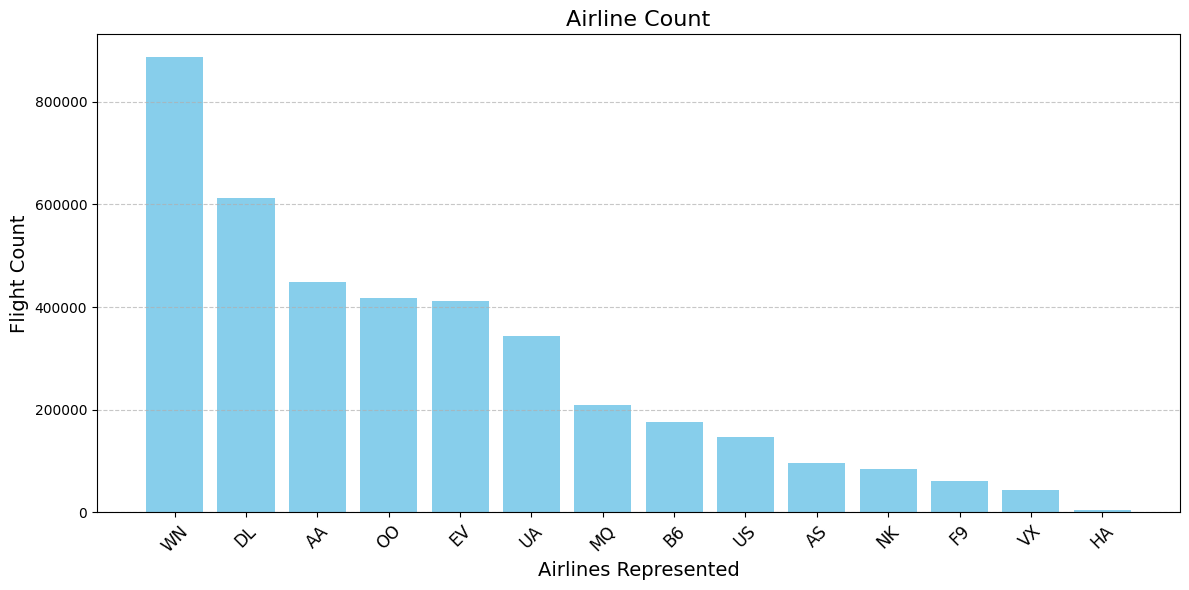

In [23]:
airline_counts = X_train.group_by("AIRLINE").count()
airline_counts = airline_counts.to_pandas()
airline_counts = airline_counts.sort_values(by="count", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(airline_counts["AIRLINE"], airline_counts["count"], color="skyblue")
plt.xlabel("Airlines Represented", fontsize=14)
plt.ylabel("Flight Count", fontsize=14)
plt.title("Airline Count", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Now for some feature importance! We have a few modeling ideas

1) Given delay, weather, location, and other features in the dataframe, can we accurately predict which airline caused the delay

2) Conversely given an airline, weather, origin, destination, and other features, can we accurately predict the total delay (arrival + departure delay)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

target = ['TOTAL_DELAY']
y_train = X_train.select(target)
X_train_total_delay = X_train.drop(target)

non_numeric_cols = [col for col in X_train_total_delay.columns if X_train_total_delay[col].dtype == pl.Utf8]
encoded_non_numeric = X_train_total_delay
for col in non_numeric_cols:
    le = LabelEncoder()
    encoded_non_numeric = encoded_non_numeric.with_columns(
        pl.Series(name=col, values=le.fit_transform(encoded_non_numeric[col].to_list()))
    )
print(non_numeric_cols)
X_train_total_delay = encoded_non_numeric
X_train_total_delay = pl.concat([X_train_total_delay, y_train], how="horizontal")
X_train_total_delay_cleaned = X_train_total_delay.filter(
    pl.col("TOTAL_DELAY").is_not_null()
)

X_train_total_delay_cleaned = X_train_total_delay_cleaned.to_pandas()
X_train_total_delay_cleaned = X_train_total_delay_cleaned.dropna()
X_train_total_delay_cleaned = pl.DataFrame(X_train_total_delay_cleaned)
X_train_total_delay_cleaned = X_train_total_delay_cleaned.drop(['DEPARTURE_DELAY', 'ARRIVAL_DELAY'])
X_train_total_delay_cleaned

['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'CANCELLATION_REASON', 'COUNTY_NAME', 'STATE_CODE', 'stability']


YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,COUNTY_NAME,STATE_CODE,date,st_code,fips,stability,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C,TOTAL_DELAY
i64,i64,i64,i64,i64,i64,i32,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i32,f64,f64,f64,f64,f64,i64,i64,datetime[ms],i64,i64,i64,f64,f64,f64,f64,f64,f64,i64
2015,6,18,4,3,1715,4739,79,17,1001,1046,9,1055,119,98,83,594,1218,6,1200,1224,0,0,4,0.0,0.0,24.0,0.0,0.0,237,19,2015-06-18 00:00:00,26,26163,0,17.211,23.478,20.344,1.906,15.344,0.0,69
2015,5,3,7,8,815,2681,197,208,815,937,11,948,142,124,110,837,1138,3,1037,1141,0,0,4,0.0,0.0,64.0,0.0,0.0,46,11,2015-05-03 00:00:00,17,17031,0,12.469,25.158,18.814,0.0,13.813,0.489,146
2015,5,3,7,13,3391,765,239,195,935,1058,16,1114,245,244,222,1845,1656,6,1540,1702,0,0,4,0.0,0.0,13.0,69.0,0.0,202,3,2015-05-03 00:00:00,6,6081,0,9.802,21.13,15.466,0.0,10.466,1.576,165
2015,7,29,3,10,1028,947,73,263,2209,2250,12,2302,168,162,139,1024,21,11,2357,32,0,0,4,0.0,0.0,5.0,30.0,0.0,59,4,2015-07-29 00:00:00,8,8031,0,14.245,29.737,21.991,0.0,16.991,0.071,76
2015,2,2,1,10,465,1700,92,58,759,1032,62,1134,104,142,74,404,1248,6,943,1254,0,0,4,38.0,0.0,153.0,0.0,0.0,75,28,2015-02-02 00:00:00,34,34013,0,-5.266,1.953,-1.657,25.519,0.0,16.657,344
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2015,6,8,1,2,65,2000,143,2,1936,1942,73,2055,314,356,274,1826,2329,9,2250,2338,0,0,4,42.0,0.0,6.0,0.0,0.0,186,31,2015-06-08 00:00:00,36,36081,0,16.07,21.23,18.65,0.0,13.65,0.0,54
2015,2,9,1,7,3185,2031,197,67,1955,2210,17,2227,79,81,61,315,2328,3,2114,2331,0,0,4,2.0,0.0,20.0,115.0,0.0,46,11,2015-02-09 00:00:00,17,17031,0,-3.842,3.107,-0.368,0.072,0.0,15.368,272
2015,4,9,4,13,3924,2110,123,208,800,816,10,826,60,59,44,302,910,5,900,915,0,0,4,0.0,0.0,14.0,1.0,0.0,94,40,2015-04-09 00:00:00,48,48201,0,22.101,28.07,25.086,0.001,20.086,0.0,31


In [25]:
target = ['TOTAL_DELAY']
y_train = X_train_total_delay_cleaned.select(target)
X_train_total_delay = X_train_total_delay_cleaned.drop(target)
X_train_total_delay = X_train_total_delay.with_columns(
    [pl.col(column).cast(pl.Int32) for column in X_train_total_delay.columns if X_train_total_delay[column].dtype == pl.Int64]
)
X_train_total_delay = X_train_total_delay.with_columns(
    [pl.col(column).cast(pl.Float32) for column in X_train_total_delay.columns if X_train_total_delay[column].dtype == pl.Float64]
)


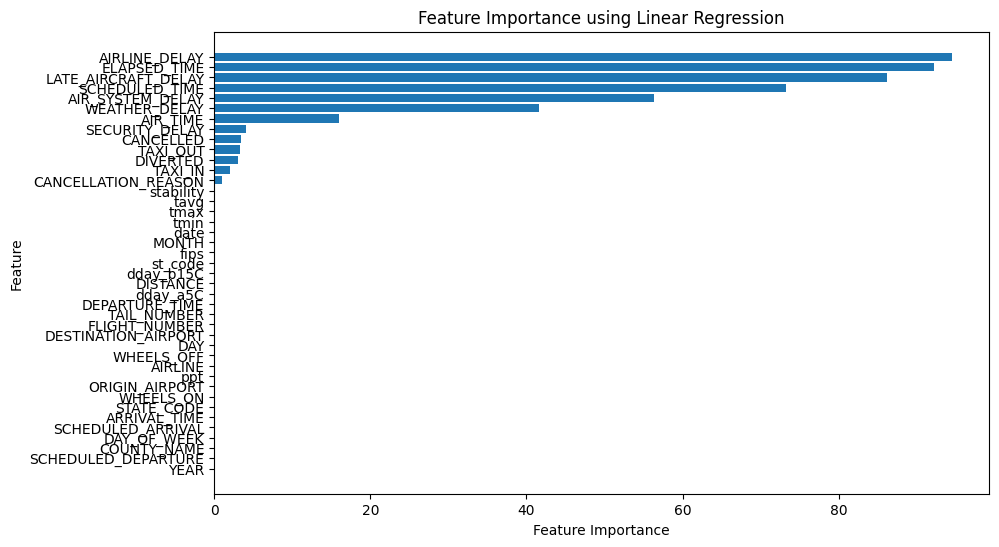

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_standardized_np = scaler.fit_transform(X_train_total_delay.to_numpy())


X_standardized = pl.DataFrame(
    X_standardized_np,
    schema=X_train_total_delay.columns
)

X_standardized = X_standardized.drop_nulls()
X_standardized_pd = X_standardized.to_pandas()

lr = LinearRegression()
lr.fit(X_standardized_pd, y_train)

coefficients = lr.coef_.ravel() if len(lr.coef_.shape) > 1 else lr.coef_

feature_importances = pd.DataFrame({
    "Feature": X_standardized.columns,
    "Importance": np.abs(coefficients)
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances["Feature"], feature_importances["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance using Linear Regression")
plt.gca().invert_yaxis()
plt.show()

# Part X: Hypothesis Testing

Now it is time to move into some hypothesis testing

We will be looking at the following hypotheses all tested with $\alpha = 0.05$ for significance:

1) When precipitation is greater than 1 is a flight more likely to be delayed?

$H_0$: When precipitation is greater than 1 a flight has the same liklihood of being delayed

2) Are flights in western, southwestern, and southeastern states less likely to be delayed than states in the midwest, new england, mid-atlantic, and northwest in winter months?

$H_0$: western, southwestern, and southeastern states are delayed the same amount as flights in the midwest, new england, mid-atlantic, and the northwest in winter months.

3) Some of us have had some bad experience with certain airlines (looking at you AA), is this the truth, are some airlines significantly more likely to have delays than others?

$H_0$: all airlines experience the same average delay

### Hypothesis 1

We want to test a population proportion in looking at the proportion of flights that are delayed (as a boolean value). So, in comparing the cases where precipitation is greater than 1 or < 1 (essentially, whether there is noticeable precipitation or not), we would be testing a difference of population proportions. The other option would be to test whether the difference by considering the actual number of minutes (i.e. the mean delay time), though we decided to use the boolean method instead. We can formulate specifically\
\
$H_0$ = p_precip - p_noprecip = 0\
$H_1$ = p_precip - p_noprecip > 0

In [27]:
precip_df = result_important_df.filter(pl.col("ppt") > 1)
noprecip_df = result_important_df.filter(pl.col("ppt") <= 1)

In [28]:
# Create a new column "IS_DELAYED" that's 1 if delayed and 0 if on time
precip_df = precip_df.with_columns(
    (pl.col('DEPARTURE_DELAY') > 0).alias('IS_DELAYED').cast(pl.Int64)
)
noprecip_df = noprecip_df.with_columns(
    (pl.col('DEPARTURE_DELAY') > 0).alias('IS_DELAYED').cast(pl.Int64)
)
delay_precip_proportion = precip_df.select(pl.sum('IS_DELAYED')) / len(precip_df)
delay_noprecip_proportion = noprecip_df.select(pl.sum('IS_DELAYED')) / len(noprecip_df)

# Calculate original test statistic (0.420968 - 0.354947 = 0.066021)
delay_proportion_diff = delay_precip_proportion[0, 0] - delay_noprecip_proportion[0, 0]

# Simulate the null world - same proportion of flights being delayed regardless of precipitation, 10,000,000 trials each
simulated_delays_precip = np.random.binomial(len(precip_df), 0.5, 10_000_000) / len(precip_df)
simulated_delays_noprecip = np.random.binomial(len(noprecip_df), 0.5, 10_000_000) / len(noprecip_df)
simulated_precip_proportion = sum(simulated_delays_precip) / len(simulated_delays_precip)
simulated_noprecip_proportion = sum(simulated_delays_noprecip) / len(simulated_delays_noprecip)
# simulated values: (0.500 - 0.499 = -3.615e-08)
simulated_proportion_diff = simulated_precip_proportion - simulated_noprecip_proportion

# Calculate the p-value (p = 0)
simulated_p_value = sum(x >= delay_proportion_diff for x in (simulated_delays_precip - simulated_delays_noprecip)) / len(simulated_delays_precip)

Since p = 0 < 0.05, we reject the null hypothesis the the proportion of delayed flights on days with precipitation > 1 is the same as when precipitation <= 1.

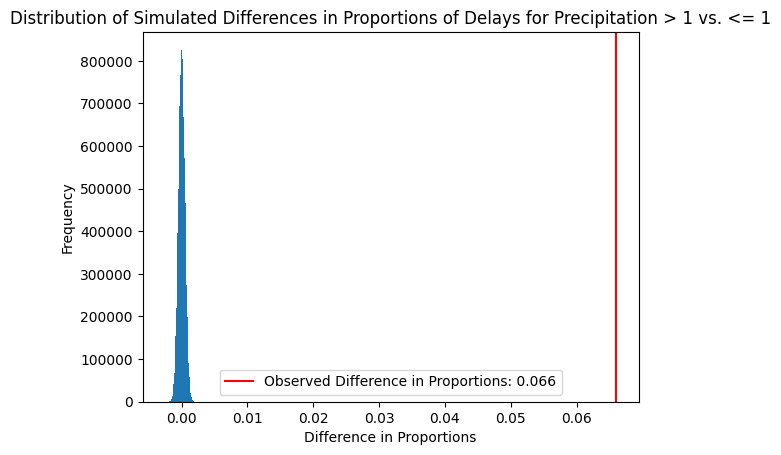

In [29]:
# Plot the distribution of simulated difference in proportions of delays for precipitation > 1 vs. <= 1
_ = plt.hist(simulated_delays_precip - simulated_delays_noprecip, bins = 50)
plt.title("Distribution of Simulated Differences in Proportions of Delays for Precipitation > 1 vs. <= 1")
plt.xlabel("Difference in Proportions")
plt.ylabel("Frequency")
round_dpd = round(delay_proportion_diff, 4)
plt.axvline(round_dpd, color = "red", label = "Observed Difference in Proportions: {}".format(round_dpd))
plt.legend()

### Hypothesis 2

Next, we want to testing the question: Are flights in western, southwestern, and southeastern states less likely to be delayed than states in the midwest, new england, mid-atlantic, and northwest in winter months? We use a similar approach in looking at a difference in population proportions, also viewing delays as a boolean characteristic. We formulate the below hypothesis:\
\
$H_0$: Western, southwestern, and southeastern states are equally as likely to be delayed as flights in the midwest, new england, and the northwest in winter months.\
$H_1$: Flights in these two groups of regions are not equally as likely to be delayed in the winter months

In [30]:
# Winter months: December - February (12, 1, 2), need to use state_to_region_dict to get region classifications
# Convert state_to_region_dict to a dataframe for joining purposes
state_to_region_df = pl.from_dict(state_to_region_dict)
states = pl.Series(state_to_region_df.columns)
state_to_region_df = state_to_region_df.transpose()
state_to_region_df = state_to_region_df.insert_column(1, states)
state_to_region_df.columns = ['region', 'STATE_CODE']
# Join result_important_df with this to add a new column with the regions
result_important_df = result_important_df.join(state_to_region_df, on = 'STATE_CODE', how = 'left')

In [31]:
# Compute smaller dfs: south = western + southerwestern + southeast, north = midwest + new england + mid-atlantic + northwest
# Then filter for winter months
south_df = result_important_df.filter((pl.col("region") == "western") | (pl.col("region") == "southwest") | (pl.col("region") == "southeast"))
north_df = result_important_df.filter((pl.col("region") == "midwest") | (pl.col("region") == "newengland") |
 (pl.col("region") == "midatlantic") | (pl.col("region") == "northwest"))
south_df = south_df.filter((pl.col("MONTH") == 12) | (pl.col("MONTH") == 1) | (pl.col("MONTH") == 2))
north_df = north_df.filter((pl.col("MONTH") == 12) | (pl.col("MONTH") == 1) | (pl.col("MONTH") == 2))

In [32]:
# Create a new column "IS_DELAYED" that's 1 if delayed and 0 if on time
south_df = south_df.with_columns(
    (pl.col('DEPARTURE_DELAY') > 0).alias('IS_DELAYED').cast(pl.Int64)
)
north_df = north_df.with_columns(
    (pl.col('DEPARTURE_DELAY') > 0).alias('IS_DELAYED').cast(pl.Int64)
)
delay_south_proportion = south_df.select(pl.sum('IS_DELAYED')) / len(south_df)
delay_north_proportion = north_df.select(pl.sum('IS_DELAYED')) / len(north_df)

# Calculate original test statistic (0.399198 - 0.386936 = 0.012262)
delay_proportion_diff1 = delay_north_proportion[0, 0] - delay_south_proportion[0, 0]

# Simulate the null world - same proportion of flights being delayed regardless of north/south, 10,000,000 trials each
simulated_delays_north = np.random.binomial(len(north_df), 0.5, 10_000_000) / len(north_df)
simulated_delays_south = np.random.binomial(len(south_df), 0.5, 10_000_000) / len(south_df)
simulated_north_proportion = sum(simulated_delays_north) / len(simulated_delays_north)
simulated_south_proportion = sum(simulated_delays_south) / len(simulated_delays_south)
# simulated values: (0.500 - 0.500 = 0)
simulated_proportion_diff1 = simulated_north_proportion - simulated_south_proportion

# Calculate the p-value (p = 0)
simulated_p_value1 = sum(x >= delay_proportion_diff1 for x in (simulated_delays_north - simulated_delays_south)) / len(simulated_delays_north)

Since p = 0 < 0.05, we reject the hypothesis that the proportion of delayed flights during winter is the same in northern and southern states

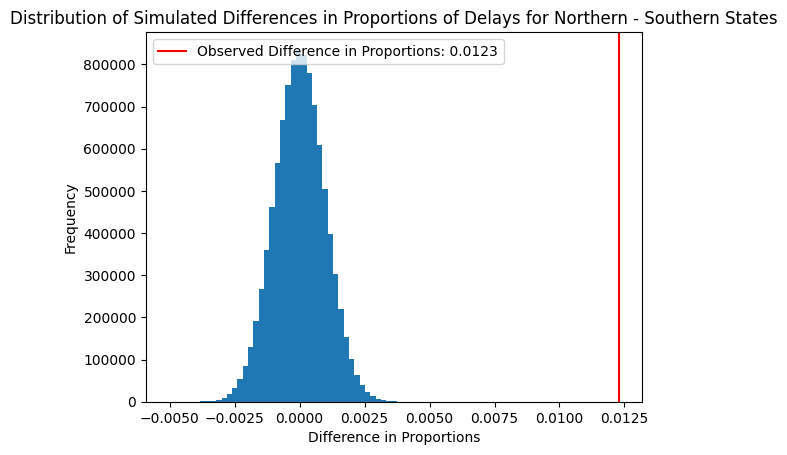

In [33]:
# Plot the distribution of simulated difference in proportions of delays for north vs. south states
_ = plt.hist(simulated_delays_north - simulated_delays_south, bins = 50)
plt.title("Distribution of Simulated Differences in Proportions of Delays for Northern - Southern States")
plt.xlabel("Difference in Proportions")
plt.ylabel("Frequency")
round_dpd = round(delay_proportion_diff1, 4)
plt.axvline(round_dpd, color = "red", label = "Observed Difference in Proportions: {}".format(round_dpd))
plt.legend()

### Hypothesis 3

For the third hypothesis, we want to test if Are some airlines significantly more likely to have delays than others? To do this, we will repeat the hypothesis test for separate airlines. We chose to consider the top three airlines by amount of flights in our dataset which are namely Southwest (WN), Delta (DL), and American (AA). In this case, rather than considering delays as a boolean, we are considering the actual number of minutes of delays. We choose the direction of the alternate (one-sided) hypothesis based on whether the observed average delay for that airline was greater than or less than the average for all flights. We formulate the hypothesis for American Airlines as follows (analogously for other airlines):\
\
$H_0$: delay_AA - delay_avg = 0 (American Airlines has the same average delay as the average delay for all airlines)\
$H_1$: delay_AA - delay_avg < 0 (American Airlines has a lower average delay than the average delay for all airlines)

In [34]:
'''
HYPOTHESIS 3
Are some airlines significantly more likely to have delays than others? (same format hypotheses for other airlines)
$H_0$: all airlines experience the same average delay
H_0: American Airlines has same average delay as overall airlines average delay (delay_AA - delay_avg = 0), H_1: delay_AA - delay_avg < 0

In this data set American and Delta Airlines has lower than average delay, Southwest has higher than average delay.
Though these are all not statistically significant.
'''
american = result_important_df.filter(pl.col('AIRLINE') == 'AA')
southwest = result_important_df.filter(pl.col('AIRLINE') == 'WN')
delta = result_important_df.filter(pl.col('AIRLINE') == 'DL')

In [35]:
# Calculate test statistics - average delay for American Airlines
aa_delay = american.select(pl.mean('DEPARTURE_DELAY'))[0, 0]

# Calculate mean (9.9388) and stdev (37.4972) for delay across all airlines
mean_delay = result_important_df.select(pl.mean('DEPARTURE_DELAY'))[0, 0]
stdev_delay = result_important_df.select(pl.std('DEPARTURE_DELAY'))[0, 0]

# Simulate the null world where American Airlines has same amount of delay, 10,000,000 trials
# I don't know if we can assume a Normal distribution but ok
simulated_delays = np.random.normal(mean_delay, stdev_delay, 10_000_000)
simulated_aa_delay = sum(simulated_delays) / len(simulated_delays)

# Calculate the p-value (p = 0.49077) this is > 0.05
simulated_p_value_aa = sum(x <= aa_delay for x in simulated_delays) / len(simulated_delays)
simulated_p_value_aa

0.4907736

Repeating the same for Southwest and Delta airlines, the other top airlines in this dataset

In [36]:
# Southwest Airlines
wn_delay = southwest.select(pl.mean('DEPARTURE_DELAY'))[0, 0]

# Calculate the p-value (p = 0.488225) this is > 0.05
simulated_p_value_wn = sum(x >= wn_delay for x in simulated_delays) / len(simulated_delays)
simulated_p_value_wn

0.4878755

In [37]:
# Delta Airlines
dl_delay = delta.select(pl.mean('DEPARTURE_DELAY'))[0, 0]

# Calculate the p-value (p = 0.4906998) this is > 0.05
simulated_p_value_dl = sum(x <= dl_delay for x in simulated_delays) / len(simulated_delays)
simulated_p_value_dl

0.4765175

With p-values of 0.49055 > 0.05, 0.488225 > 0.05, and 0.47657 > 0.05 we fail to reject H_0 that average delay for American Airlines, Southwest Airlines, and Delta Airlines are each significantly lower than average delay for all airlines. These are separate hypothesis tests, just writing them all in the same sentence.

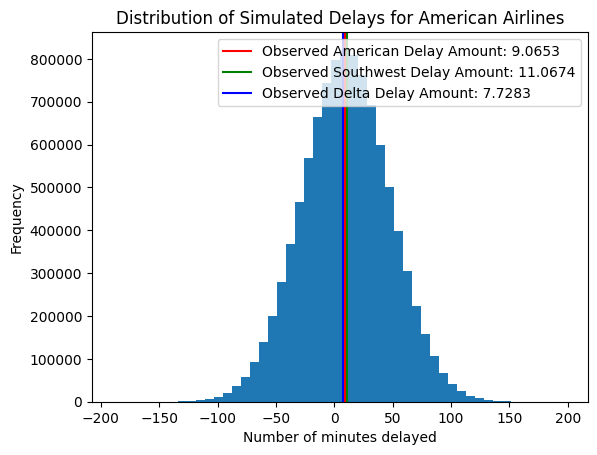

In [38]:
# Plot the distribution of simulated delay times for American Airlines
_ = plt.hist(simulated_delays, bins = 50)
plt.title("Distribution of Simulated Delays for American Airlines")
plt.xlabel("Number of minutes delayed")
plt.ylabel("Frequency")

round_aa = round(aa_delay, 4)
plt.axvline(round_aa, color = "red", label = "Observed American Delay Amount: {}".format(round_aa))

round_wn = round(wn_delay, 4)
plt.axvline(round_wn, color = "green", label = "Observed Southwest Delay Amount: {}".format(round_wn))

round_dl = round(dl_delay, 4)
plt.axvline(round_dl, color = "blue", label = "Observed Delta Delay Amount: {}".format(round_dl))

plt.legend()

MODELING!

In [39]:
target = "DEPARTURE_DELAY"
print(result_important_df.filter(result_important_df[target] > 0).shape)
print(result_important_df.filter(result_important_df[target] <= 0).shape)

(1844064, 45)
(3010652, 45)


In [40]:
binary_results_df = result_important_df.with_columns(
    pl.when(result_important_df[target] > 0)
    .then(1)
    .otherwise(0)
    .alias("IS_DELAYED")  # Replace the column with the modified values
)

In [38]:
binary_results_df.head()

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,COUNTY_NAME,STATE_CODE,date,st_code,fips,stability,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C,TOTAL_DELAY,region,IS_DELAYED
i64,i64,i64,i64,str,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,str,str,date,i64,i64,str,f64,f64,f64,f64,f64,f64,i64,str,i32
2015,1,1,4,"""AA""",2336,"""N3KUAA""","""LAX""","""PBI""",10,2,-8,12,14,280,279,263,2330,737,4,750,741,-9,0,0,null,null,null,null,null,null,"""los angeles""","""CA""",2015-01-01,6,6037,"""stable""",-2.162,7.71,2.774,0.009,0.621,12.226,-17,"""west""",0
2015,1,1,4,"""US""",840,"""N171US""","""SFO""","""CLT""",20,18,-2,16,34,286,293,266,2296,800,11,806,811,5,0,0,null,null,null,null,null,null,"""san mateo""","""CA""",2015-01-01,6,6081,"""stable""",2.561,12.746,7.654,0.0,3.173,7.346,3,"""west""",0
2015,1,1,4,"""AA""",258,"""N3HYAA""","""LAX""","""MIA""",20,15,-5,15,30,285,281,258,2342,748,8,805,756,-9,0,0,null,null,null,null,null,null,"""los angeles""","""CA""",2015-01-01,6,6037,"""stable""",-2.162,7.71,2.774,0.009,0.621,12.226,-14,"""west""",0
2015,1,1,4,"""AS""",135,"""N527AS""","""SEA""","""ANC""",25,24,-1,11,35,235,215,199,1448,254,5,320,259,-21,0,0,null,null,null,null,null,null,"""king""","""WA""",2015-01-01,53,53033,"""stable""",-6.204,0.605,-2.8,0.061,0.0,17.8,-22,"""northwest""",0
2015,1,1,4,"""DL""",806,"""N3730B""","""SFO""","""MSP""",25,20,-5,18,38,217,230,206,1589,604,6,602,610,8,0,0,null,null,null,null,null,null,"""san mateo""","""CA""",2015-01-01,6,6081,"""stable""",2.561,12.746,7.654,0.0,3.173,7.346,3,"""west""",0


In [41]:
from sklearn.model_selection import train_test_split

binary_results_df = binary_results_df.to_pandas()

numeric_features = ["SCHEDULED_DEPARTURE", "SCHEDULED_TIME","YEAR","MONTH","DAY","DAY_OF_WEEK","DISTANCE","tmin","tmax","tavg","ppt","dday_a5C","dday_b15C"]

X = binary_results_df[numeric_features]
y = binary_results_df['IS_DELAYED']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(3946641, 13)
(986661, 13)


In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3946641 entries, 3648064 to 1692743
Data columns (total 13 columns):
 #   Column               Dtype  
---  ------               -----  
 0   SCHEDULED_DEPARTURE  int64  
 1   SCHEDULED_TIME       float64
 2   YEAR                 int64  
 3   MONTH                int64  
 4   DAY                  int64  
 5   DAY_OF_WEEK          int64  
 6   DISTANCE             int64  
 7   tmin                 float64
 8   tmax                 float64
 9   tavg                 float64
 10  ppt                  float64
 11  dday_a5C             float64
 12  dday_b15C            float64
dtypes: float64(7), int64(6)
memory usage: 421.5 MB


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(clf.score(X_test,y_test))

0.6671126151738034


In [41]:
feature_importances = clf.feature_importances_
for feature, importance in zip(X.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature: SCHEDULED_DEPARTURE, Importance: 0.2562
Feature: SCHEDULED_TIME, Importance: 0.1805
Feature: YEAR, Importance: 0.0000
Feature: MONTH, Importance: 0.0244
Feature: DAY, Importance: 0.0452
Feature: DAY_OF_WEEK, Importance: 0.0260
Feature: DISTANCE, Importance: 0.1727
Feature: tmin, Importance: 0.0590
Feature: tmax, Importance: 0.0580
Feature: tavg, Importance: 0.0543
Feature: ppt, Importance: 0.0380
Feature: dday_a5C, Importance: 0.0490
Feature: dday_b15C, Importance: 0.0368


In [42]:
numeric_features = ["SCHEDULED_DEPARTURE", "SCHEDULED_TIME","YEAR","MONTH","DAY","DAY_OF_WEEK","DISTANCE","tmin","tmax","tavg","ppt","dday_a5C","dday_b15C"]

X = binary_results_df[numeric_features]
y = binary_results_df['IS_DELAYED']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(3946641, 13)
(986661, 13)


In [43]:
binary_results_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,stability,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C,TOTAL_DELAY,region,IS_DELAYED
0,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,stable,-2.162,7.710,2.774,0.009,0.621,12.226,-17.0,west,0
1,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,stable,2.561,12.746,7.654,0.000,3.173,7.346,3.0,west,0
2,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,stable,-2.162,7.710,2.774,0.009,0.621,12.226,-14.0,west,0
3,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,stable,-6.204,0.605,-2.800,0.061,0.000,17.800,-22.0,northwest,0
4,2015,1,1,4,DL,806,N3730B,SFO,MSP,25,...,stable,2.561,12.746,7.654,0.000,3.173,7.346,3.0,west,0


In [52]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the XGBoost classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=True, eval_metric='logloss')

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [1, 2, 5],
}


# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=2,
    verbose=1,
)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)

# Print the best parameters and accuracy score
print("Best Parameters:", best_params)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Fitting 2 folds for each of 243 candidates, totalling 486 fits
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200}
Test Accuracy: 0.6840252123069626
